In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import (named_colors, mpl_loc,
    fancy_legend, load_mpl_presets, append_axes, markers, append_axes)
import vice
import numpy as np
import math as m
import random
import sys
sys.path.append("..")
from src.utils import linear_exponential, exponential, chisquared
load_mpl_presets()
print(sys.version_info)

/var/home/johnson.7419.local/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../data/wukong/wukong.dat")
data = vice.dataframe({})
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]
print(len(data["[fe/h]"]))

57


/var/home/johnson.7419.local/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


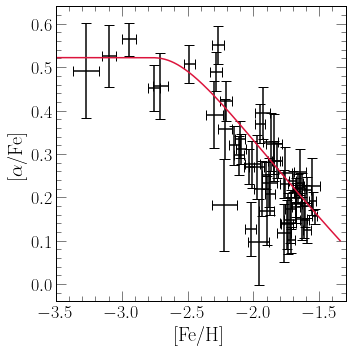

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-3.5, -1.3])
ax.set_ylim([-0.04, 0.64])

# med_feh_err = np.median(data["[fe/h]_err"])
# med_ofe_err = np.median(data["[o/fe]_err"])
# ax.scatter(data["[fe/h]"], data["[o/fe]"], c = named_colors()["black"], s = 20)
# ax.errorbar(-3, 0.2, xerr = med_feh_err, yerr = med_ofe_err, c = named_colors()["black"])
ax.errorbar(data["[fe/h]"], data["[o/fe]"], xerr = data["[fe/h]_err"], yerr = data["[o/fe]_err"],
    c = named_colors()["black"], linestyle = "None")

duration = 1.46
with vice.singlezone(name = "wukong") as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential(prefactor = 1000)
    sz.func.timescale
    sz.mode = "ifr"
    sz.Mg0 = 0
    sz.eta = 10.33
    sz.tau_star = 25.25
    sz.dt = duration / 1000
    vice.yields.ccsne.settings['o'] = 0.01
    vice.yields.sneia.settings['o'] = 0
    vice.yields.ccsne.settings['fe'] = 6.78e-4
    vice.yields.sneia.settings['fe'] = 3.64e-3
    bfout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)

ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], c = named_colors()["crimson"])
    

plt.tight_layout()
plt.show()

In [9]:
cosmological_age = 13.2
quantities = list(filter(lambda _: not _.endswith("_err"), data.keys()))
# sub = vice.dataframe(mock.todict())
# sub["age"] = [m.log10(_) for _ in sub["age"]]
# sub["age_err"] = [0.1 if not m.isnan(_) else float("nan") for _ in sub["age"]]
sample = np.array([data[key] for key in quantities]).T
errors = np.array([data["%s_err" % (key)] for key in quantities]).T
model = len(bfout.history["time"]) * [None]
for i in range(len(model)):
    model[i] = len(quantities) * [0.]
    for j in range(len(quantities)):
#         if quantities[j] == "age":
#             model[i][j] = m.log10(bfout.history["lookback"][i] + cosmological_age - bf_duration)
#         else:
        model[i][j] = bfout.history[quantities[j]][i]
model = model[1:] # chop off the -inf [Fe/H] predicted at t = 0
weights = bfout.history["sfr"][1:]
N = 0
for i in range(len(sample)):
    for j in range(len(sample[i])):
        if not m.isnan(sample[i][j]): N += 1
print(N)
chisq = chisquared(sample, errors, model, weights)
print(chisq / (N - 6))

114
0.9273885442657985
